# Выбор локации для скважины

Допустим, мы трудимся в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом **100 000** месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Для начала **импортируем библиотеки**, которые будем использовать в ходе исследования:

In [1]:
# импорт библиотеки pandas
import pandas as pd

# импорт библиотеки pnumpy
import numpy as np
from numpy.random import RandomState

# импорт pyplot из библиотеки matplotlib
import matplotlib.pyplot as plt

# импорт библиотеки seaborn
import seaborn as sns

# импортируем train_test_split из модуля sklearn.model_selection
from sklearn.model_selection import train_test_split 

# импортируем LinearRegression
from sklearn.linear_model import LinearRegression

# импортируем mean_squared_error
from sklearn.metrics import mean_squared_error

Прочитаем файлы `geo_data_0.csv`, `geo_data_1.csv` и `geo_data_2.csv` c данными геологоразведки трёх регионов из папки `/datasets`. 

Cохраним содержимое в соответствующих переменных:

In [2]:
# чтение файла с данными и сохранение в geo_data_0
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')

# чтение файла с данными и сохранение в geo_data_1
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')

# чтение файла с данными и сохранение в geo_data_2
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Для автоматизированного знакомства с данными зададим массив названий доступных нам датафреймов:

In [3]:
#массив названий таблиц для знакомства с данными
array_datasets_names = ['geo_data_0', 
                        'geo_data_1', 
                        'geo_data_2']

Теперь с помощью цикла применем метод `info()` к каждой таблице и ознакомимся с результатами:

In [4]:
#цикл для вывода информации о таблицах
for name in array_datasets_names:
    print('\033[94m'+'\033[1m'+
        'Информация о таблице: ', 
        name +'\033[0m'+'\033[0m')
    locals()[name].info()
    print()

Информация о таблице:  geo_data_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Информация о таблице:  geo_data_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Информация о таблице:  geo_data_2
<class 'pandas.core.frame.Da

Итак, нам предоставлены пробы нефти в **трёх регионах**: в каждом **100 000** месторождений, где измерили качество нефти и объём её запасов. В исходных таблицах нет пропущенных значений. В каждой таблице по 5 столбцов.

Проведём первичное знакомство с данными каждой таблицы с помощью цикла и метода `head()`:

In [5]:
#цикл для вывода первых строк таблиц
for name in array_datasets_names:
    print('\033[94m'+'\033[1m'+'Первые строки таблицы: ', name +'\033[0m'+'\033[0m')
    display(locals()[name].head())
    print()

Первые строки таблицы:  geo_data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Первые строки таблицы:  geo_data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Первые строки таблицы:  geo_data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Из описания данных известно:

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (на данном этапе неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

С помощью цикла ознакомимся с характеристиками выборки количественных признаков:

In [6]:
#цикл для вывода первых строк таблиц
for name in array_datasets_names:
    print('\033[94m'+'\033[1m'+'Характеристика выборки признаков: ', name +'\033[0m'+'\033[0m')
    display(locals()[name].describe())
    print()

Характеристика выборки признаков:  geo_data_0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Характеристика выборки признаков:  geo_data_1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Характеристика выборки признаков:  geo_data_2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Как видно из результата признаки `f0`, `f1` и `f2` имеют примерно одинаковый масштаб, поэтому масштабирование признаков скорее всего не потребуется.

Проверим колличественные признаки на мультиколлинеарность с использованием диаграммы рассеяния:

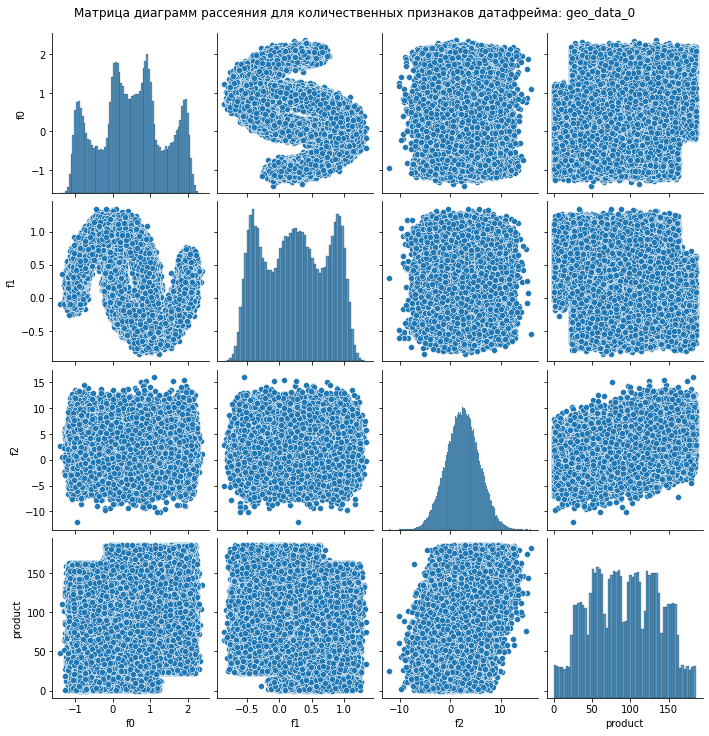

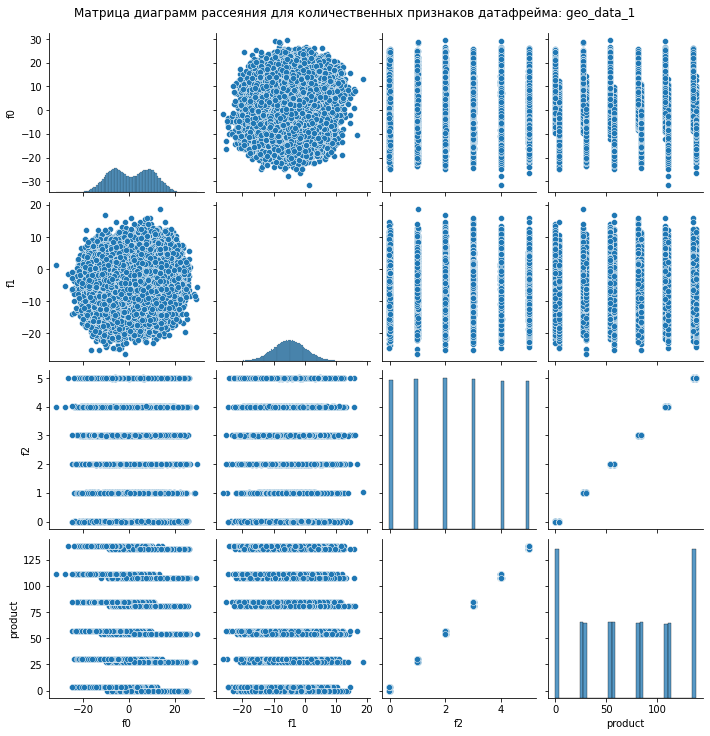

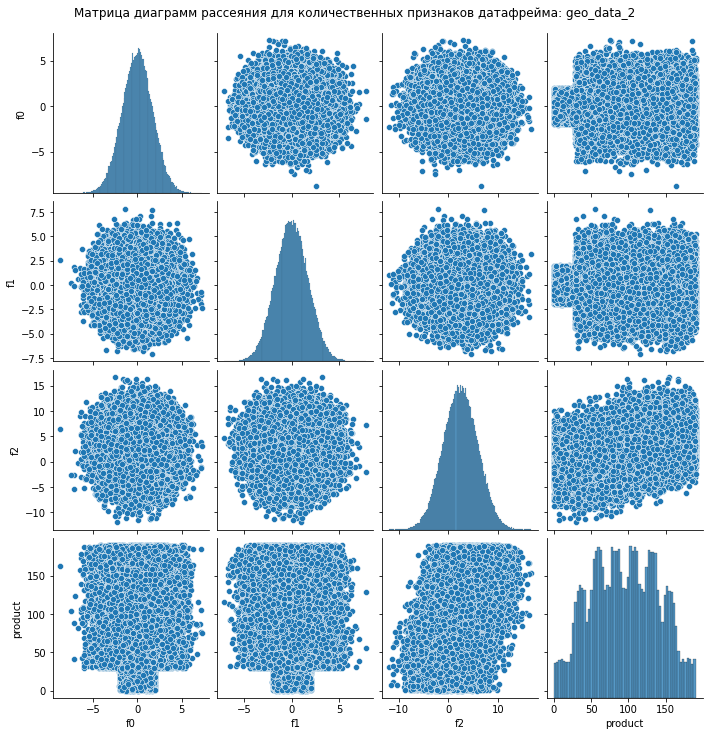

In [7]:
#построим матрицу диаграмм рассеяния
for name in array_datasets_names:
    
    (sns.pairplot(locals()[name][["f0", "f1", "f2", "product"]])
     .fig.suptitle("Матрица диаграмм рассеяния для количественных признаков датафрейма: "+name,y=1.02))

    plt.show()

В данном случае **матрица диаграмм рассеяния** очень удобна для анализа: по диагонали мы видим как распределены значения в исходной выборке каждого признака. Диаграмма позволяет визуально оценить: есть ли зависимость между признаками, на которых мы будем обучать модель в дальнейшем.

Распределения всех количественных признаков в регионах `0` и `2` близки к нормальному.

Следует отметить, что *целевой признак* в регионе `1` **не распределён нормально**: примерно одинаковое количество данных с примерно одинаковым результатом по объёмам производства, а также два *выбивающихся значения* по краям выборки.

Из матрицы диаграмм рассеяния видно, что зависимость целевого признака `product` от других количественных признаков отличается для всех трех наборов данных:
- в случае данных `geo_data_1` мы видим почти категориальную зависимость `product` от `f0`, `f1` и `f2`,
- в случае `geo_data_0` и `geo_data_2` целевой признак `product` похожим образом зависит от `f2`, но зависимости отличаются для `f0` и `f1`. 

Также с помощью тепловой карты визуализируем значение коэффициента корреляции Пирсона:

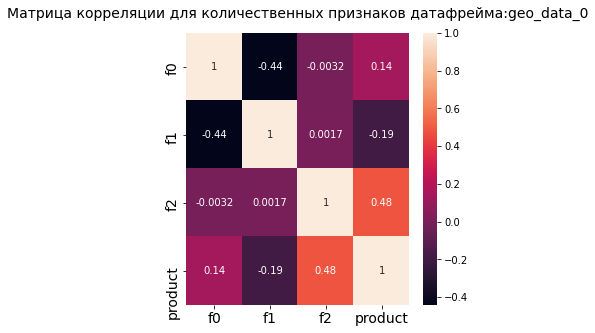

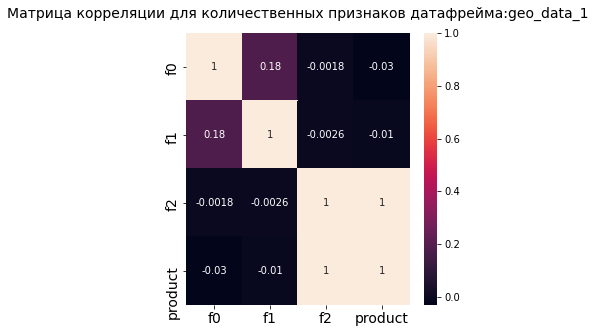

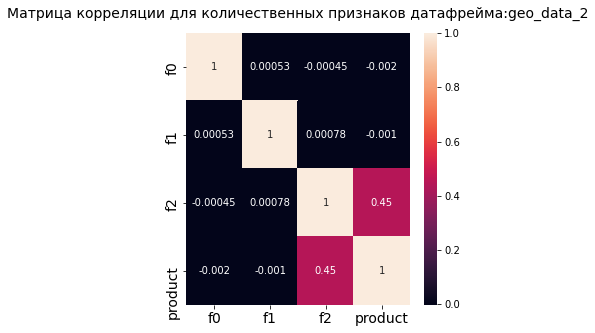

In [8]:
for name in array_datasets_names:
    plt.figure(figsize=(5,5))
    
    sns.heatmap(
        locals()[name][["f0", "f1", "f2", "product"]]
        .corr(),
        annot=True)
    
    #название графика
    plt.title('Матрица корреляции для количественных признаков датафрейма:'+name, 
              fontsize=14, 
              loc='center',
              pad=15)

    #задаём размер значений на оси абсцисс и на оси ординат
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.show()

Очевидно, что некоторые признаки мультиколлинеарны:
- в `geo_data_0`:
    - отрицательную зависимость имеют `f0` и `f1`, но по графику видно, что зависимость между ними сложнее чем линейная, 
    - положительную зависимость имеют `f2` и `product`,
- в `geo_data_1`: сильная поолжительная зависимость между `f2` и `product`,
- в `geo_data_2`: положительная зависимость между `f2` и `product`.

### Вывод

Мы выполнили предварительное знакомство с данными. Определили, что целевой признак для 3-х регионов - это столбец `product`. 

Из рассмотрения можно удалить столбец `id`, так как он не приведёт к улучшению модели.

Мы посмотроили матрицу диаграмм рассеяния для количественных признаков исходных датафреймов, увидели, что характер зависимости целевого признака `product` от других признаков отличается для всех трех регионов. Особенно выделяется регион `1` (в дальнейшем для удобства будет нумеровать их по датасетам: `0`, `1`, `2`): зависимость целевого признака в нём зависит от других напоминает категориальную, а не количественную.

Мы проверили признаки на мультиколлинеарность, увидели, что некоторые признаки обладают этим свойством, но в дальнейшем будем рассматривать все признаки, представленные в задаче.

Перейдём к обучению и проверки моделей.

## Обучение и проверка модели

Из условия задачи мы знаем: для обучения модели подходит **только линейная регрессия** (остальные — недостаточно предсказуемые).

Поэтому создадим функцию, которая будет принимать на вход датафрейм, а возвращать - ряд параметров, которые важны нам в дальнейшем:
 - `features_train_geo_data`, `target_train_geo_data`, `features_valid_geo_data`, `target_valid_geo_data` - функция будет осуществлять деление выборки валидационную и обучающущю в соотношении 75% к 25%,
 - `model_geo_data` - будем сохранять модель, обученную на тренировочной выборке,
 - `predicted_valid_geo_data` - сохраним предсказания для каждого региона,
 - `mse_geo_data` - здесь сохраним MSE (средняя квадратичная ошибка),
 - `rmse_geo_data` - также нам понадобится RMSE (квадратный корень из средней квадратичной ошибки),
 - `mean_predicted_valid_geo_data` - среднее значение предсказаний по региону.
 
Как уже понятно из данных, которые мы получим в результате работы функции, внутри неё мы будем:
- делить выборку на обучающую и валидационную,
- создавать модель линейной регрессии,
- обучать модель на тренировочной выборке,
- сохранять предсказания на валидационной,
- рассчитывать MSE и RMSE,
- находить среднее значение всех предсказаний.

Функцию затем мы сможем применить внутри цикла и выполнить расчеты сразу для трех регионов.

Целевой признак - `product`, признаки - все кроме `id` и `product`.

Теперь запишем функцию `model_for_geo_data`:

In [9]:
#функция для деления данных на выборки, обучения модели, вычисления RMSE и среднего значения предсказаний
def model_for_geo_data(geo_data):

    #целевой признак
    target_geo_data = geo_data['product']
    
    #признаки
    features_geo_data = geo_data.drop(['id','product'] , axis=1)
    
    #разбиваем данные на обучающую и валидационную выборки в соотношении 75% к 25%
    (features_train_geo_data, 
     features_valid_geo_data, 
     target_train_geo_data, 
     target_valid_geo_data) = train_test_split(features_geo_data, 
                                                 target_geo_data, 
                                                 test_size=0.25, 
                                                 random_state=12345)
    
    #создаём модель линейной регрессии
    model_geo_data = LinearRegression()
    
    #обучаем модель на тренировочной выборке
    model_geo_data.fit(features_train_geo_data, 
                         target_train_geo_data)
    
    #делаем предсказания на валидационной выборке
    predicted_valid_geo_data = model_geo_data.predict(features_valid_geo_data)
    
    #расчитываем MSE на валидационной выборке
    mse_geo_data = mean_squared_error(target_valid_geo_data,
                                      predicted_valid_geo_data)
    
    #расчитываем RMSE на валидационной выборке
    rmse_geo_data = mse_geo_data ** 0.5
    
    #находим среднее значение всех предсказаний
    mean_predicted_valid_geo_data = predicted_valid_geo_data.mean()
    
    return (features_train_geo_data, 
            features_valid_geo_data, 
            target_train_geo_data, 
            target_valid_geo_data,
            model_geo_data,
            predicted_valid_geo_data,
            mse_geo_data,
            rmse_geo_data,
            mean_predicted_valid_geo_data)


Теперь с помощью цикла применяем функцию **сразу к 3 регионам**:

In [10]:
#применяем функцию `model_for_geo_data` сразу к 3 реагионам,
#результаты сохраняем в соответствующих переменных
for name in array_datasets_names:
    (locals()['features_train_'+name], #признаки обучающей выборки
     locals()['features_valid_'+name], #признаки валидационной выборки
     locals()['target_train_'+name],   #целевой признак обучающей выборки
     locals()['target_valid_'+name],   #целевой признак валидационной выборки
     locals()['model_'+name],          #модель линейной регрессии, обученная на тренировочной выборке
     locals()['predicted_valid_'+name],#предсказания на валидационной выборке
     locals()['mse_'+name],            #MSE на валидационной выборке
     locals()['rmse_'+name],           #RMSE на валидаицонной выборке
                                       #среднее значение предсказний и вызов функции
     locals()['mean_predicted_valid_'+name]) = model_for_geo_data(locals()[name]) 

Запишем результаты в виде сводной таблицы:

In [11]:
table_1 = pd.DataFrame({'Регион':[array_datasets_names[0],
                                  array_datasets_names[1],
                                  array_datasets_names[2]],
                        'Cредний запас предсказанного сырья':[mean_predicted_valid_geo_data_0,
                                                              mean_predicted_valid_geo_data_1,
                                                              mean_predicted_valid_geo_data_2],
                        'RMSE': [rmse_geo_data_0,
                                 rmse_geo_data_1,
                                 rmse_geo_data_2],
                       })

table_1

,Регион,Cредний запас предсказанного сырья,RMSE
0,geo_data_0,92.592568,37.579422
1,geo_data_1,68.728547,0.893099
2,geo_data_2,94.965046,40.029709


В результате мы видим, что квадратный корень из средней квадратичной ошибки **наименьший** для `geo_data_1`, но мы также помним особенность зависимости `product` от признаков `f0`, `f1` и `f2`.

Примерно одинаковые значения среднего запаса предсказанного сырья получились для регионов `0` и `2`. Также `RMSE` для них получился примерно одинаковым, но относительно большим от среднего значения: около 40%. Но это вполне нормально, так как модель предсказывает разные значения для разных скважин, разброс здесь неизбежен.

Нам предстоит определить наиболее перспективный регион. На данном этапе сложно делать предварительные выводы, поэтому продолжим исследование.

### Вывод

Мы разбили данные на обучающую и валидационные выборки, создали и обучили модели линейной регрессии для каждого региона, сохранили предсказания моделей на валидационной выборке, рассчитали RMSE.

Наименьший корень из средней квадратичной ошибки, как и наименьший запас предсказанного сырья, наблюдается в регионе `1`. Но это связано со спецификой иходных данных по этому региону и с характером распределения целевого признака `product` в правильных ответах.

В регионах `0` и `2` средние значения запаса предсказанного сырья близки, как и значения RMSE. Поэтому для принятия решения потребуются дополнительные исследования.

## Подготовка к расчёту прибыли

Выполним подготовку к расчету прибыли.

Все ключевые значения для расчётов сохраним в отдельных переменных.

- Бюджет на разработку скважин в регионе — 10 млрд рублей:

In [12]:
#бюджет на разработку скважин в регионе - 10 млрд рублей
budget_oiler = 10e9

- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [13]:
#доход с каждой единицы продукта составляет - 450 тыс. рублей
revenue_product_unit = 450000

- При разведке региона исследуют 500 точек:

In [14]:
#количество точек для исследования
research_points_number = 500

- Из которых с помощью машинного обучения выбирают 200 лучших для разработки:

In [15]:
#200 лучших точек для разработки
best_points_number = 200

Теперь рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

Для этого:
- разделим общий бюджет (10 млрд. руб.) на количество лучших точек (200), получим доступный бюджет на одну скважину,
- далее бюджет одной скважины разделим на доход с единицы продукции (450 тыс. руб.),
- получим объём продукции с одной скважины, который нужен, чтобы покрыть вложения на её разработку.

Итак, достаточный объём сырья для безубыточной разработки новой скважины:

In [16]:
#достаточный объём сырья для безубыточной разработки новой скважины
breakeven_volume_per_oiler = (budget_oiler/200)/revenue_product_unit

#выводим на экран
breakeven_volume_per_oiler

111.11111111111111

Сравним полученный объём сырья со средним запасом в каждом регионе.
Для этого ещё раз выведем ренее созданную сводную таблицу:

In [17]:
table_1

,Регион,Cредний запас предсказанного сырья,RMSE
0,geo_data_0,92.592568,37.579422
1,geo_data_1,68.728547,0.893099
2,geo_data_2,94.965046,40.029709


Мы видим, что средний запас предсказанного сырья для трех регионов меньше чем наименьший объём для безубыточной разработки новой скважины. Высокое значение RMSE для регионов `0` и `2` говорит о том, что есть скважины, превышающие полученное средние значение. Поэтому нам важно будет в дальнейшем правильно выбрать скважины, чтобы разработка не была в убыток предприятию.

### Вывод

Выполнена подготовка к расчету прибыли:
- Все ключевые значения для расчётов сохранены в отдельных переменных. 
- Рассчитан достаточный объём сырья для безубыточной разработки новой скважины, который составляет около **111,1 единиц**.
- Средний запас предсказанного сырья для трех регионов меньше чем наименьший объём для безубыточной разработки новой скважины. Поэтому в дальнейшем важно будет правильно выбрать те скважины, которые принесут предприятию прибыль и не будут убыточными.



## Расчёт прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

**Важно**, что мы внутри функции будем *выбирать 200 лучших скважин на основе предсказаний модели*, а считать прибыль будем на **основе известных данных о реальном объёме** в этих скважинах, то есть, используя правильные ответы:

In [18]:
def profit_calculation(predicted_valid, target_valid):
    
    #отбираем 200 лучших скважин
    best_oilers = pd.Series(predicted_valid).sort_values(ascending=False).head(best_points_number)
    
    #удаляем индексы целевого признака
    target_valid = target_valid.reset_index(drop=True)
    
    #суммируем реальное значение объёма сырья в этих скважинах (используем правильные ответы)
    sum_volume = target_valid[target_valid.index.isin(best_oilers.index)==True].sum()
    
    #рассчитаем доход для полученного объёма сырья
    revenue = sum_volume*revenue_product_unit
    
    #рассчитаем прибыль для полученного объёма сырья
    profit = revenue - budget_oiler
    
    #функция возвращает реальный объём в 200 скважинах и прибыль
    return (sum_volume, profit)

Снова воспользуемся циклом и рассчитаем прибыль и объёмы сырья для трех регионов:

In [19]:
for name in array_datasets_names:
    (locals()['sum_volume_'+name],
     locals()['profit_'+name]) = profit_calculation(locals()['predicted_valid_'+name],
                                                    locals()['target_valid_'+name])

Визуализируем результат расчета прибыли с помощью сводной таблицы:

In [20]:
table_2 = pd.DataFrame({'Регион':[array_datasets_names[0],
                                  array_datasets_names[1],
                                  array_datasets_names[2]],
                        'Реальный запас сырья на 200 лучших по предсказаниям скважин':[sum_volume_geo_data_0,
                                                                                         sum_volume_geo_data_1,
                                                                                         sum_volume_geo_data_2],
                        'Прибыль для полученного объёма сырья': [profit_geo_data_0,
                                                                 profit_geo_data_1,
                                                                 profit_geo_data_2],
                       })

table_2

,Регион,Реальный запас сырья на 200 лучших по предсказаниям скважин,Прибыль для полученного объёма сырья
0,geo_data_0,29601.835651,3.320826e+09
1,geo_data_1,27589.081548,2.415087e+09
2,geo_data_2,28245.222141,2.710350e+09


### Вывод

Мы получили, что по предсказаниям модели в каждом из рассматриваемых регионов можно выбрать 200 скважин, которые вероятно позволят преодолеть порог безубыточности, составляющий в нашем случае 10 млрд. затраченных рублей на разработку двух сотен скважен.

Однако, регион `0` по результатам предсказаний модели более перспективный, чем регион `2`. Наименее перспективный - регион `1`, если будем работать в нём, то получим только около 2,4 млр. руб. прибыли сверх затраченных денег.

Более перспективен регион `0`, так как в нём прибыль может составить от до 3,3 млрд. руб.

Для взвешенного принятия решения требуется анализ рисков.

## Расчёт рисков 

Посчитаем риски и прибыль для каждого региона.

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Создадим объект `RandomState()` из модуля `numpy.random`, чтобы из-за указания `random_state` случайный элемент не был всегда одинаковый:

In [21]:
state = RandomState(12345)

Этот объект можно передавать аргументу `random_state` в любой функции. Важно, что при каждом новом вызове его состояние будет меняться на случайное. Так получим разные подвыборки.

Ещё одна важная деталь при создании подвыборок — они должны обеспечить выбор элементов с возвращением. То есть один и тот же элемент может попадать в подвыборку несколько раз. Для этого укажем аргумент `replace=True` в функции `sample()`.

Сделаем функцию для реализации метода бутстреп, в которую будем передавать данные региона и ранее обученную на тренировочной выборке модель для этого региона.

Внутри функции:
- будет реализован метод `bootstrap` с помощью функции `sample()`, где на каждом шаге цикла из исходного набора данных для региона будет выбираться случайная подвыборка из 500 точек для признаков по региону,
- из подвыборки для 500 точек будем выделять признаки и целевой признак,
- ранее обученную на тренировочной выборке модель будем использовать для выбора наиболее перспективных 200 из 500 скважин,
- для выбранных моделью 200 скважин будем считать прибыль с использованием готового ответа, т.е. будем учитывать реальный объём сырья и реальную прибыль,
- будем сохранять рассчитанное значение прибыли для 200 лучших скважин на каждом шаге `bootstrap`,
- после цикла для сохранённого массива значений прибыли будем вычислять среднее значение, вероятность риска отрицательной прибыли, а также границы доверительного интервала (2,5% и 97,5% квантили).

Запишем данную функцию:

In [22]:
def risk_estimation(geo_data,model_geo_data):
    
    values = []
    
    for i in range(1000):
        
        #используем функцию sample() для реализации метода bootstrap
        subsample = geo_data.sample(n=research_points_number, replace=True, random_state=state)
        
        #выделяем признаки и целевой признак
        features_subsample = subsample.drop(['id','product'] , axis=1).reset_index(drop=True)
        target_subsample = subsample['product'].reset_index(drop=True)
        
        #делаем предсказания на валидационной выборке
        predicted_bs_geo_data = model_geo_data.predict(features_subsample)
        
        #отбираем 200 лучших из 500 случайно выбранных скважин
        best_oilers = pd.Series(predicted_bs_geo_data).sort_values(ascending=False).head(best_points_number)
                
        #суммируем реальное значение объёма сырья в этих скважинах (мы уже используем правильные ответы)
        sum_volume = target_subsample[target_subsample.index.isin(best_oilers.index)==True].sum()
        
        #рассчитаем доход для полученного объёма сырья
        revenue = sum_volume*revenue_product_unit
        
        #рассчитаем прибыль для полученного объёма сырья
        profit = revenue - budget_oiler
        
        #сохраняем массив прибыли для всех итераций бустрепа
        values.append(profit)
    
    values = pd.Series(values)      #преобразуем массив в Series
    
    mean_profit = values.mean()     #средняя прибыль по региону
    lower = values.quantile(0.025)  #нижняя граница доверительного интервала
    upper = values.quantile(0.975)  #верхняя граница доверительного интервала
    
    #вычисляем риск отрицательной прибыли
    risk_prob = (values<0).mean()*100
    
    return (risk_prob, mean_profit, lower, upper)

С помощью цикла применем функцию к 3 регионам:

In [23]:
for name in array_datasets_names:
    (locals()['risk_prob_'+name],
     locals()['mean_profit_'+name],
     locals()['lower_'+name],
     locals()['upper_'+name]) = risk_estimation(locals()[name], 
                                                locals()['model_'+name])

Визуализируем результаты с помощью сводной таблицы:

In [24]:
table_3 = pd.DataFrame({'Регион':[array_datasets_names[0],
                                  array_datasets_names[1],
                                  array_datasets_names[2]],
                        'Вероятность отрицательной прибыли,%: ':[risk_prob_geo_data_0,
                                                               risk_prob_geo_data_1,
                                                               risk_prob_geo_data_2],
                        'Средняя прибыль по региону на 1000 выборок:': [mean_profit_geo_data_0,
                                                                        mean_profit_geo_data_1,
                                                                        mean_profit_geo_data_2],
                        '2,5% квантиль:':[lower_geo_data_0,
                                          lower_geo_data_1,
                                          lower_geo_data_2],
                        '97,5% квантиль:':[upper_geo_data_0,
                                           upper_geo_data_1,
                                           upper_geo_data_2]
                       })

table_3

,Регион,"Вероятность отрицательной прибыли,%:",Средняя прибыль по региону на 1000 выборок:,"2,5% квантиль:","97,5% квантиль:"
0,geo_data_0,5.2,4.241498e+08,-7.785692e+07,9.685807e+08
1,geo_data_1,1.0,4.348214e+08,4.241964e+07,8.038451e+08
2,geo_data_2,8.2,3.865366e+08,-1.467015e+08,8.784200e+08


### Вывод

Расчет прибыли по 200 лучшим скважинам валидационной выборки показывал, что все три региона могут быть прибыльными. Причем наименьшую прибыль имел регион `1`. 

Однако оценка риска отрицательной прибыли и доверительного интервала методом `bootstrap` показала, что лучше отдать предпочтение региону `1`, так как это единственный регион из трех, в котором вероятность отрицательной прибыли **менее 2,5%**.

Мы также помним характеристику выборки `product` региона `1` - она более предсказуемая, если можно так выразиться, в сравнении с выборками `0` и `2`, так как не имеет явного пика, поэтому и менее рискованная.

## Общий вывод

Для разработки скважин предлагается регион `1`, так как в нём, в сравнении с регионами `0` и `2`, наименьшая вероятность отрицательной прибыли: около 1%.

В регионах `0` и `2` вероятность отрицательной прибыли, рассчитанная техникой `bootstrap` превышает **2,5%**.

Однако регионы `0` и `2` потенциально могут принести бОльшую прибыль чем регион `1`, но как было сказано выше, возрастает вероятность отрицательной прибыли.